Data Preproceesing & Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
import shap

c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('Mobile-Phones.csv')

In [3]:
data.head()

,brand,model,sd_card,main_camera,resolution,display,sim_card,os,color,region,location,screen_size(inch),battery(mAh),storage(GB),ram(GB),selfie_camera(MP),price(¢)
0,Samsung,Galaxy S10,yes,"3 Cameras: 12, 12, 16 MP",1440 x 3040,AMOLED,Single,Android,White,Greater Accra,Circle,6.10,3400.0,128.0,8.0,10.0,2450
1,Samsung,Galaxy Note 20 Ultra,yes,"3 Cameras: 108, 12, 12 MP",1440 x 3088,AMOLED,Dual,Android,Bronze,Greater Accra,Circle,6.90,4500.0,128.0,12.0,10.0,5000
2,Samsung,Galaxy A54 5G,yes,"3 Cameras: 50, 12, 5 MP",1080 x 2340,Super AMOLED,Dual,Android,Black,Greater Accra,Accra Metropolitan,6.40,5000.0,256.0,8.0,32.0,3000
3,Tecno,Camon 20 Pro,no,"2 Cameras: 64, 2 MP",1080 x 2400,AMOLED,Dual,Android,Black,Greater Accra,Accra Metropolitan,6.67,5000.0,256.0,8.0,32.0,1900
4,Samsung,Galaxy S22 Ultra,no,"4 Cameras: 108, 10, 10, 12 MP",1400 x 3088,AMOLED,Dual,Android,Black,Greater Accra,Accra Metropolitan,6.80,5000.0,512.0,12.0,40.0,5750


In [4]:
# Dropping columns before encoding
data = data.drop(columns=['color', 'region', 'location'])

In [5]:
# Combining 'brand' and 'model' into one column
data['brand_model'] = data['brand'] + '_' + data['model']
data = data.drop(columns=['brand', 'model'])

In [6]:
data.columns

Index(['sd_card', 'main_camera', 'resolution', 'display', 'sim_card', 'os',
       'screen_size(inch)', 'battery(mAh)', 'storage(GB)', 'ram(GB)',
       'selfie_camera(MP)', 'price(¢)', 'brand_model'],
      dtype='object')

In [7]:
#Imputation
missing_values = data.isnull().sum()
print(missing_values)

sd_card                0
main_camera          235
resolution           536
display              566
sim_card             790
os                   219
screen_size(inch)    127
battery(mAh)         170
storage(GB)            3
ram(GB)              788
selfie_camera(MP)    307
price(¢)               0
brand_model            0
dtype: int64


In [8]:
# Specific imputation for 'os' column
data.loc[data['brand_model'].str.contains('iPhone'), 'os'] = 'iOS'

In [9]:
# Handle different cases of 'iOS'
#To prevent identifying iOS and IOS as different instances
data['os'] = data['os'].str.replace('IOS', 'iOS', case=False)

In [10]:
#Categorical and numerical features
categorical_features = data.select_dtypes(exclude=['int64', 'float64']).columns
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
print(categorical_features)
print(numerical_features)

Index(['sd_card', 'main_camera', 'resolution', 'display', 'sim_card', 'os',
       'brand_model'],
      dtype='object')
Index(['screen_size(inch)', 'battery(mAh)', 'storage(GB)', 'ram(GB)',
       'selfie_camera(MP)', 'price(¢)'],
      dtype='object')


In [11]:
# Imputation for numerical columns
imputer_num = SimpleImputer(strategy='median')
data[numerical_features] = imputer_num.fit_transform(data[numerical_features])

# Imputation for categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_features] = imputer_cat.fit_transform(data[categorical_features])

In [12]:
print(data.shape)

(3600, 13)


In [13]:
#Encoding
categorical_features_to_encode = data.select_dtypes(include=['object']).columns.tolist()

# Initialize LabelEncoder
label_encoders = {}

# Applying Label Encoding
for col in categorical_features_to_encode:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [14]:
#The first few rows of the encoded data
print(data.head())

   sd_card  main_camera  resolution  display  sim_card  os  screen_size(inch)  \
0        1           52          37        0         2   1               6.10   
1        1           48          38        0         0   1               6.90   
2        1           79           9       14         0   1               6.40   
3        0           45          12        0         0   1               6.67   
4        0           92          33        0         0   1               6.80   

   battery(mAh)  storage(GB)  ram(GB)  selfie_camera(MP)  price(¢)  \
0        3400.0        128.0      8.0               10.0    2450.0   
1        4500.0        128.0     12.0               10.0    5000.0   
2        5000.0        256.0      8.0               32.0    3000.0   
3        5000.0        256.0      8.0               32.0    1900.0   
4        5000.0        512.0     12.0               40.0    5750.0   

   brand_model  
0          302  
1          297  
2          270  
3          362  
4      

In [15]:
# Correlation matrix
correlation_matrix = data.corr()

# Extract the correlation values for the 'price'
price_correlation = correlation_matrix['price(¢)'].sort_values(ascending=False)

# Display the correlations
print(price_correlation)

price(¢)             1.000000
storage(GB)          0.535488
ram(GB)              0.469087
main_camera          0.305906
os                   0.295094
screen_size(inch)    0.229024
battery(mAh)         0.213944
selfie_camera(MP)    0.118282
resolution           0.081343
sim_card            -0.015571
brand_model         -0.145006
display             -0.180596
sd_card             -0.359763
Name: price(¢), dtype: float64


Exploratory Data Analysis

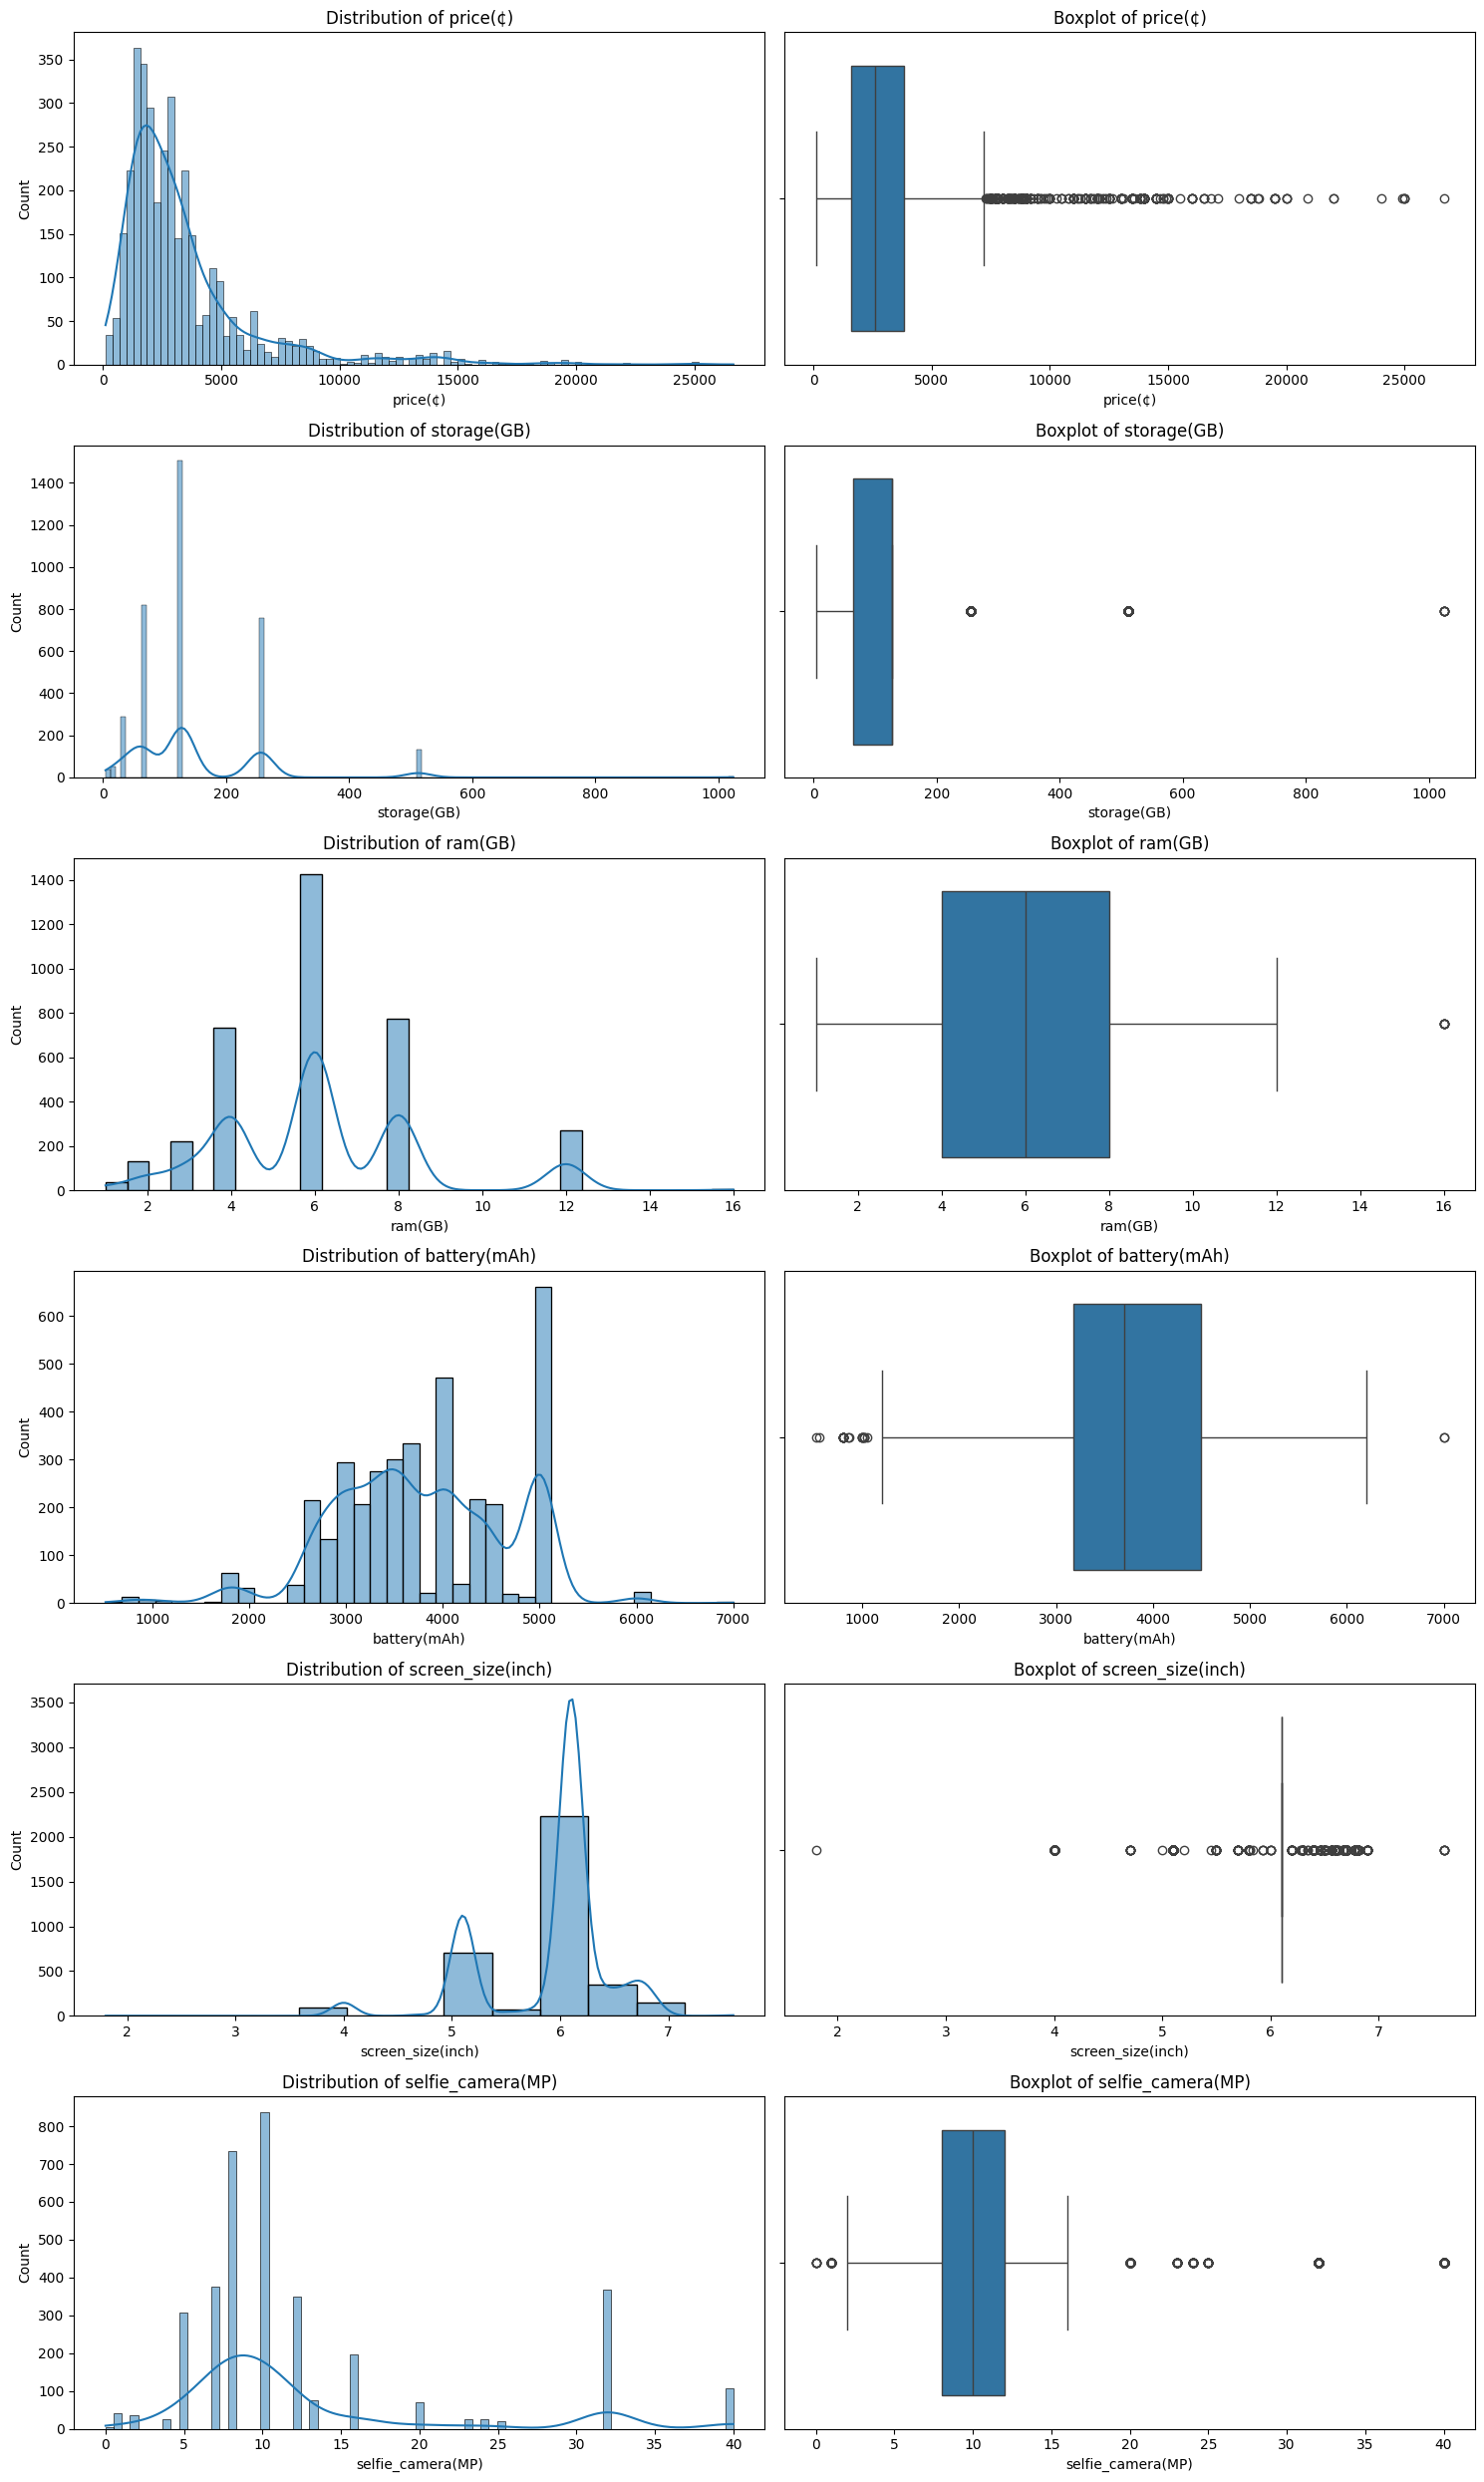

In [16]:
# Key numerical features for visualization
key_numerical_features = ['price(¢)', 'storage(GB)', 'ram(GB)', 'battery(mAh)', 'screen_size(inch)', 'selfie_camera(MP)']

# Plotting the distributions of key numerical features using histograms and boxplots
fig, axes = plt.subplots(len(key_numerical_features), 2, figsize=(15, 25))

for i, feature in enumerate(key_numerical_features):
    # Histogram
    sns.histplot(data[feature], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Distribution of {feature}')
    
    # Boxplot
    sns.boxplot(x=data[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

KEY INSIGHTS

PRICE DISTRIBUTION:

The price distribution is highly right-skewed, indicating that most mobile phones are priced at the lower end, with a few very high-priced outliers.
The boxplot confirms the presence of several high-priced outliers beyond 10,000 ¢.


STORAGE (GB):

The distribution of storage shows multiple peaks, suggesting the presence of distinct storage capacity categories (e.g., 64GB, 128GB, 256GB, etc.).
The boxplot indicates several outliers in storage capacities, particularly in the higher ranges.


RAM (GB):

RAM distribution also shows multiple peaks, which likely correspond to common RAM sizes such as 4GB, 8GB, 16GB etc.
The boxplot suggests that the majority of devices fall within a standard range

BATTERY CAPACITY (mAh):

The distribution of battery capacity is fairly spread out with a notable peak around 4000 mAh, which is a common battery capacity for many smartphones.
The boxplot shows some high-capacity outliers, but most values are concentrated around the median.


SCREEN SIZE (Inches):

Screen size distribution shows peaks around standard sizes, especially around 6 inches, which is common for many smartphones.
The boxplot highlights a few outliers, especially for smaller and larger screen sizes.


SELFIE CAMERA (MP):

The distribution of selfie camera megapixels is also multi-modal, indicating standard configurations such as 8MP, 12MP, and higher.
The boxplot shows a few outliers, particularly at higher megapixel counts, but most values are concentrated within the interquartile range.


OVERALL OBSERVATIONS:

OUTLIERS:

Many features have notable outliers, particularly in price and storage capacity.

MULTIMODAL DISTRIBUTIONS: 

Several features (e.g., storage, RAM, screen size, selfie camera) exhibit multi-modal distributions, suggesting that there are standard configurations in the mobile phone market that cater to specific consumer preferences and market demands

In [17]:
# SHAP values
X = data.drop(columns=['price(¢)'])
y = data['price(¢)']

Feature Importance

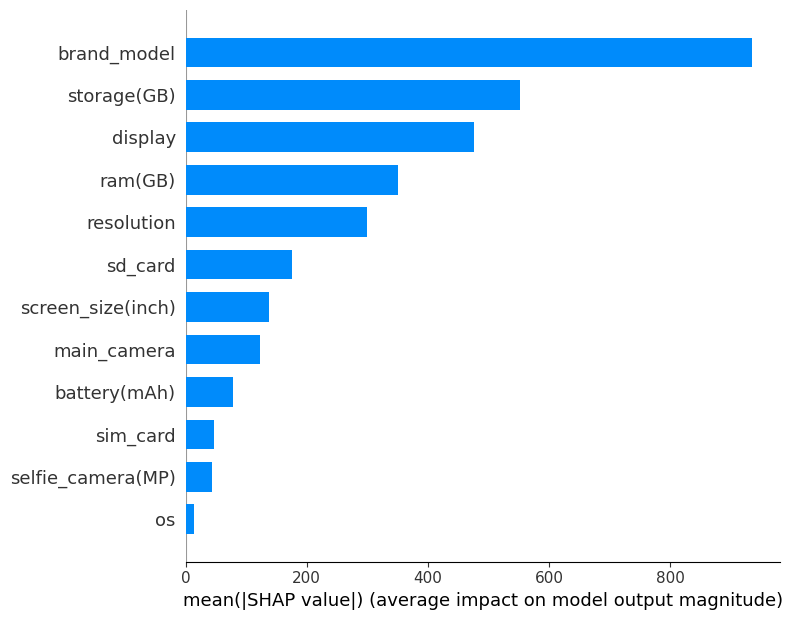

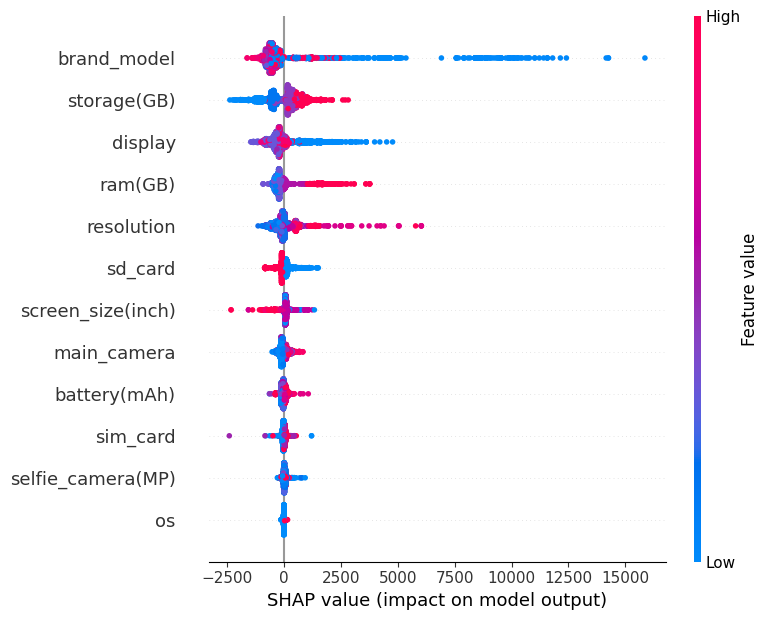

In [18]:
# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Calculate SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# Visualize the feature importance
shap.summary_plot(shap_values, X, plot_type="bar")

# Visualize the detailed SHAP summary plot for all features
shap.summary_plot(shap_values, X)

# Show plots
plt.show()

Key Insights from the SHAP Summary Plot:

Brand & Model :

 Different brands and models can greatly affect the predicted price due to brand reputation, quality, and market positioning. High-end brands and popular models tend to command higher prices.


Storage (GB):


Phones with higher storage capacities are generally more expensive. Consumers often pay a premium for more storage to store apps, photos, and videos.


Display:


The quality, resolution, and technology of the display (e.g., OLED vs. LCD) are crucial factors in determining a phone's price. Better and larger displays enhance the user experience, leading to higher prices.


RAM (GB):


Explanation: More RAM generally enhances a phone's performance, allowing it to run applications more smoothly and handle multitasking better. Consequently, phones with more RAM are typically priced higher.


Resolution:


 High-resolution screens provide a superior viewing experience, which can justify a higher price. Consumers are often willing to pay more for phones with better screen clarity and detail.

In [19]:
# List of relevant features
relevant_features = ['brand_model','storage(GB)', 'ram(GB)', 'display', 'resolution']

# Include the target variable
relevant_features.append('price(¢)')

#A new DataFrame with only the relevant features
relevant_data = data[relevant_features]

print(relevant_data.head())

   brand_model  storage(GB)  ram(GB)  display  resolution  price(¢)
0          302        128.0      8.0        0          37    2450.0
1          297        128.0     12.0        0          38    5000.0
2          270        256.0      8.0       14           9    3000.0
3          362        256.0      8.0        0          12    1900.0
4          321        512.0     12.0        0          33    5750.0


Training of Models & Evaluation

In [20]:
# Define the features (X) and the target variable (y)
X = relevant_data.drop(columns=['price(¢)'])
y = relevant_data['price(¢)']

# Split the data into training, validation, and testing sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [21]:

# Define parameter grids for GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

gbr_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Function to create the Keras model
def create_nn_model():
    model = Sequential()
    model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

nn_model = KerasRegressor(model=create_nn_model, verbose=0)

nn_param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 200]
}

In [22]:
# Model training with GridSearchCV
rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=3, scoring='neg_mean_squared_error')
gbr_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=gbr_param_grid, cv=3, scoring='neg_mean_squared_error')
nn_grid_search = GridSearchCV(estimator=nn_model, param_grid=nn_param_grid, cv=3, scoring='neg_mean_squared_error')

rf_grid_search.fit(X_train_scaled, y_train)
gbr_grid_search.fit(X_train_scaled, y_train)
nn_grid_search.fit(X_train_scaled, y_train)

c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in

c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in

GridSearchCV(cv=3,
             estimator=KerasRegressor(model=<function create_nn_model at 0x000002764CE5CF40>, verbose=0),
             param_grid={'batch_size': [32, 64, 128], 'epochs': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [23]:
# Predictions and evaluation for machine learning models
rf_y_pred = rf_grid_search.best_estimator_.predict(X_test_scaled)
gbr_y_pred = gbr_grid_search.best_estimator_.predict(X_test_scaled)
nn_y_pred = nn_grid_search.best_estimator_.predict(X_test_scaled)

In [24]:

# Calculate RMSE, MAE, and R² for each model
model_performance = {
    "Random Forest": {
        "Best_Params": rf_grid_search.best_params_,
        "RMSE": np.sqrt(mean_squared_error(y_test, rf_y_pred)),
        "MAE": mean_absolute_error(y_test, rf_y_pred),
        "R2": r2_score(y_test, rf_y_pred)
    },
    "Gradient Boosting": {
        "Best_Params": gbr_grid_search.best_params_,
        "RMSE": np.sqrt(mean_squared_error(y_test, gbr_y_pred)),
        "MAE": mean_absolute_error(y_test, gbr_y_pred),
        "R2": r2_score(y_test, gbr_y_pred)
    },
    "Neural Network": {
        "Best_Params": nn_grid_search.best_params_,
        "RMSE": np.sqrt(mean_squared_error(y_test, nn_y_pred)),
        "MAE": mean_absolute_error(y_test, nn_y_pred),
        "R2": r2_score(y_test, nn_y_pred)
    }
}

In [25]:
# Create DataFrame from model performance dictionary
model_performance_df = pd.DataFrame(model_performance).T

# Display the DataFrame
print(model_performance_df)

                                                         Best_Params  \
Random Forest      {'bootstrap': True, 'max_depth': 20, 'min_samp...   
Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 3, 'min_sa...   
Neural Network                     {'batch_size': 32, 'epochs': 200}   

                          RMSE         MAE        R2  
Random Forest       861.344875  418.950417  0.890053  
Gradient Boosting   860.422772  486.043462  0.890288  
Neural Network     1270.962608  744.520367  0.760615  


In [26]:
# Define the base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('nn', KerasRegressor(model=create_nn_model, epochs=200, batch_size=32, verbose=0))
]

In [27]:
# Define the meta-model
meta_model = LinearRegression()

# Define the stacking regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Train the stacking regressor
stacking_regressor.fit(X_train_scaled, y_train)

# Make predictions
stacking_pred = stacking_regressor.predict(X_test_scaled)

c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in

In [28]:
# Calculate evaluation metrics
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_pred))
stacking_mae = mean_absolute_error(y_test, stacking_pred)
stacking_r2 = r2_score(y_test, stacking_pred)

# Print the evaluation metrics
print(f"Stacking Regressor RMSE: {stacking_rmse}")
print(f"Stacking Regressor MAE: {stacking_mae}")
print(f"Stacking Regressor R²: {stacking_r2}")

Stacking Regressor RMSE: 832.8314192953967
Stacking Regressor MAE: 425.7118566278218
Stacking Regressor R²: 0.8972114422601956


In [29]:
# Expanded GBR parameter grid for thorough tuning
gbr_param_grid_2 = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

gbr_grid_search_2 = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=gbr_param_grid_2, cv=3, scoring='neg_mean_squared_error')
gbr_grid_search_2.fit(X_train_scaled, y_train)
gbr_y_pred_2 = gbr_grid_search_2.best_estimator_.predict(X_test_scaled)

model_performance = {
    "Gradient Boosting": {
        "Best_Params": gbr_grid_search_2.best_params_,
        "RMSE": np.sqrt(mean_squared_error(y_test, gbr_y_pred)),
        "MAE": mean_absolute_error(y_test, gbr_y_pred),
        "R2": r2_score(y_test, gbr_y_pred)
    }
}
model_performance

{'Gradient Boosting': {'Best_Params': {'learning_rate': 0.01,
   'max_depth': 11,
   'min_samples_leaf': 6,
   'min_samples_split': 2,
   'n_estimators': 500,
   'subsample': 0.7},
  'RMSE': 860.4227722458503,
  'MAE': 486.0434619149693,
  'R2': 0.8902879417812701}}

In [30]:
# Parameter grid for the stacking regressor
stacking_param_grid = {
    'final_estimator__fit_intercept': [True, False],
}

# GridSearchCV for stacking regressor
stacking_grid_search = GridSearchCV(estimator=stacking_regressor, param_grid=stacking_param_grid, cv=3, scoring='neg_mean_squared_error')
stacking_grid_search.fit(X_train_scaled, y_train)

# Make predictions
stacking_pred = stacking_grid_search.best_estimator_.predict(X_test_scaled)

# Calculate evaluation metrics
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_pred))
stacking_mae = mean_absolute_error(y_test, stacking_pred)
stacking_r2 = r2_score(y_test, stacking_pred)

# Print the evaluation metrics
print(f"Stacking Regressor RMSE: {stacking_rmse}")
print(f"Stacking Regressor MAE: {stacking_mae}")
print(f"Stacking Regressor R²: {stacking_r2}")

c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\RONEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in

Stacking Regressor RMSE: 833.6583825359868
Stacking Regressor MAE: 427.0568707966919
Stacking Regressor R²: 0.897007212307897


Stacking Regressor is the best performing model after training with the lowest RMSE & MAE values and the highest R_2 score

Saving Model & Encoders

In [31]:
import joblib
joblib.dump(stacking_regressor, 'stacking_regressor.pkl')
joblib.dump(scaler, 'scalers.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [32]:
features_used_for_training = [
    'storage(GB)', 'brand_model','ram(GB)', 'display', 
    'resolution'
]

joblib.dump(features_used_for_training, 'features_used_for_training.pkl')

# Save the phone features DataFrame
feature_df_path = 'phone_features.pkl'
joblib.dump(X, feature_df_path)


['phone_features.pkl']